# Clustering Documents Tweets

http://scikit-learn.org/stable/auto_examples/text/document_clustering.html

http://adilmoujahid.com/posts/2014/07/twitter-analytics/

https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/



In [1]:
import codecs
import glob
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import string
import time

#nltk.download()
%matplotlib inline
from ggplot import *
from math import log
from matplotlib import pyplot as plt
from nltk import sent_tokenize, word_tokenize
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from scipy import ndimage
from sklearn import manifold, datasets
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from time import time


In [2]:
path_prep_files = 'Streaming/' #iot_results.json
all_files =  glob.glob(path_prep_files+'*.txt')
print (all_files)
token_arr = []
path = 'Streaming/'

['Streaming\\iot_data_130516.txt', 'Streaming\\iot_data_140516.txt', 'Streaming\\iot_data_150516.txt', 'Streaming\\iot_data_160516.txt', 'Streaming\\iot_data_170516.txt', 'Streaming\\iot_data_180516.txt']


In [3]:
tokens_list = []

regex_str = [
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

regex_rem = [
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
tokens_remove = re.compile(r'('+'|'.join(regex_rem)+')', re.VERBOSE | re.IGNORECASE)

punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via']

def tokenize(s):
    '''tokens = nltk.word_tokenize(text)
    return tokens'''
    return tokens_re.findall(s)
          
def preprocess(s, lowercase=True):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token.lower() for token in tokens]
    return tokens         

counter = 0


def tw2tfidf(json_file):
    corpus=[]
    with open(json_file, 'r') as f:
        for line in f:
            tweet = json.loads(line)
            tweetString=""
            for term in preprocess(tweet['text']):
                if not tokens_remove.search(term) and term not in stop:
                    tweetString = tweetString + term + " "
            corpus.append(tweetString)
    corpus=np.unique(corpus)
    tfidf = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
    tfs = tfidf.fit_transform(corpus)
    return tfs

def plot_clust_dbscan(day_tfs):
    neigh = NearestNeighbors(4,metric="euclidean",n_jobs=-1)
    k_nearest_neighb=neigh.fit(day_tfs)  
    distances, indices = k_nearest_neighb.kneighbors(day_tfs)
    epsilon= min(distances[:, [3]][distances[:, [3]]>0])

    db = DBSCAN(eps=epsilon, min_samples=4).fit(day_tfs)
    db_labels = db.labels_
    n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)

    print('Estimated number of clusters: %d' % n_clusters)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(day_tfs, db_labels))
    unique, counts = np.unique(db_labels, return_counts=True)
    #print np.asarray((unique, counts)).T

    theta = np.linspace(0.0, 2 * np.pi, n_clusters, endpoint=False)
    radii = sorted(counts[1:]/float(sum(counts[1:])))
    width = np.pi /(n_clusters/2.)
    ax = plt.subplot(111, projection='polar')
    bars = ax.bar(theta, radii, width=width, bottom=0.0)
    for r, bar in zip(radii, bars):
        bar.set_facecolor(plt.cm.jet(r / float(n_clusters)))
        bar.set_alpha(0.5)
    plt.title("Tam relat cluster")
    plt.show()

    plt.plot(sorted(distances[:, [1]]),"-",label="1")
    plt.plot(sorted(distances[:, [2]]),"-",label="2")
    plt.plot(sorted(distances[:, [3]]),"-",label="3")
    #plt.xlim(3200,4200)
    plt.ylim(0,1.01)
    plt.legend()
    plt.title("k-vecinos cercanos")
    plt.xlabel('Puntos ordenados')
    plt.ylabel('Distancia')
    plt.grid(True)
    plt.show()

    pca = PCA(n_components=2)
    pca_tfs=pca.fit(day_tfs.toarray())
    pca_tfs_tr=pca.fit(day_tfs.toarray()).transform(day_tfs.toarray())
    plt.scatter(pca_tfs_tr[:,0],pca_tfs_tr[:,1], alpha=0.3,edgecolors='none')
    plt.title("PCA")
    plt.xlabel('Primer Componente')
    plt.ylabel('Segundo Componente')
    plt.grid(True)
    plt.show()


In [4]:
print(tokens_list)
counter2 = 0

with open(path+'iot_data_160516.txt', 'r') as f:
    for line in f:
        counter+=1
        if counter == 2000:
            break;
        tweet = json.loads(line)
        tweetString = ""
        for term in preprocess(tweet['text']):
            if not tokens_remove.search(term) and term not in stop:
                tweetString = tweetString + term + " "
        tokens_list.append(tweetString)


'''tokens_list = tokens_list + [term for term in preprocess(tweet['text']) if term not in stop]'''
print counter
'''print tokens_list_clr'''

tfidf = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
tfs = tfidf.fit_transform(tokens_list)

print "Dimensiones tf-idf",tfs.shape
print tfidf
print tfidf.idf_
print tfs


[]
2000
Dimensiones tf-idf (1999, 1490)
TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.5, max_features=None, min_df=2,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)
[ 7.50229017  6.65499231  7.50229017 ...,  7.50229017  7.50229017
  7.50229017]
  (0, 87)	0.501898312092
  (0, 311)	0.497804969396
  (0, 1109)	0.498383768881
  (0, 1022)	0.501898312092
  (1, 1464)	0.519781773664
  (1, 496)	0.57269375854
  (1, 1460)	0.550733300656
  (1, 43)	0.313913361047
  (2, 173)	0.333981443979
  (2, 629)	0.561461419186
  (2, 320)	0.366816718451
  (2, 559)	0.662316363159
  (3, 87)	0.501898312092
  (3, 311)	0.497804969396
  (3, 1109)	0.498383768881
  (3, 1022)	0.501898312092
  (4, 6

### Identify best K

C:\Anaconda2\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


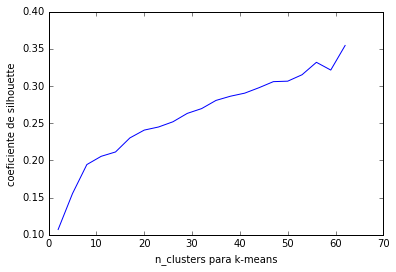

In [5]:
k_range = range(2,65,3)

start = time()
# Fit the kmeans model for each n_clusters = k

k_means_var = [KMeans(init='k-means++', n_clusters=k, n_init=10, n_jobs=-1).fit(tfs) for k in k_range]
Res_Silhouette=[metrics.silhouette_score(tfs, cluster.labels_, sample_size=15000) for cluster in k_means_var]
%matplotlib inline 
plt.plot(k_range, Res_Silhouette,"-")
plt.xlabel("n_clusters para k-means")
plt.ylabel("coeficiente de silhouette")
plt.show()

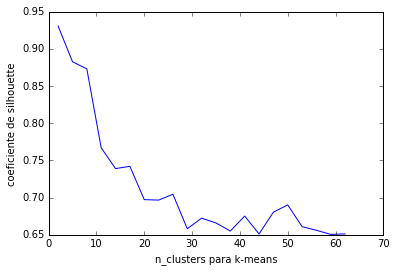

In [6]:
k_range = range(2,65,3)
svd = TruncatedSVD(n_components=2)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
reduced_data = lsa.fit_transform(tfs)

start = time()
# Fit the kmeans model for each n_clusters = k

k_means_var = [KMeans(init='k-means++', n_clusters=k, n_init=10, n_jobs=-1).fit(reduced_data) for k in k_range]
Res_Silhouette=[metrics.silhouette_score(reduced_data, cluster.labels_, sample_size=15000) for cluster in k_means_var]
%matplotlib inline 
plt.plot(k_range, Res_Silhouette,"-")
plt.xlabel("n_clusters para k-means")
plt.ylabel("coeficiente de silhouette")
plt.show()

### Graphics



In [7]:
t0 = time()
svd = TruncatedSVD(n_components=2)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

reduced_data = lsa.fit_transform(tfs)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

t0 = time()
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10, n_jobs=1)

print(reduced_data)
kmeans.fit(tfs)
kmeans.fit(reduced_data)
print("done in %0.3fs" % (time() - t0))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(reduced_data, kmeans.labels_, sample_size=15000))


done in 0.029000s
Explained variance of the SVD step: 14%
[[ 0.99995318 -0.00967708]
 [ 0.03228668  0.99947865]
 [ 0.01003043  0.99994969]
 ..., 
 [ 0.11505848  0.99335872]
 [ 0.01335641  0.9999108 ]
 [ 0.00934349  0.99995635]]
done in 1.820s
Silhouette Coefficient: 0.765


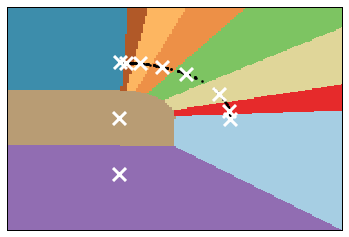

Hallo


In [8]:
x_min, x_max = reduced_data[:, 0].min()-1, reduced_data[:, 0].max()+1
y_min, y_max = reduced_data[:, 1].min()-1, reduced_data[:, 1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
          extent=(xx.min(), xx.max(), yy.min(), yy.max()),
          cmap=plt.cm.Paired,
          aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=4)
centroids = kmeans.cluster_centers_
inert = kmeans.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1],
           marker='x', s=169, linewidths=3,
           color='w', zorder=8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()
print ("Hallo")

## DBScan

In [9]:
tfs_all=[tw2tfidf(json_file) for json_file in all_files]

### Primer día


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:57: DeprecationWarning: Passing additional arguments to the metric function as **kwargs is deprecated and will no longer be supported in 0.18. Use metric_params instead.


Estimated number of clusters: 14
Silhouette Coefficient: -0.268


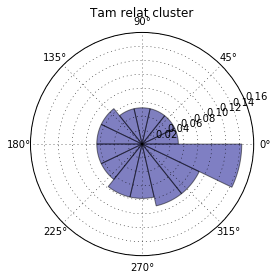

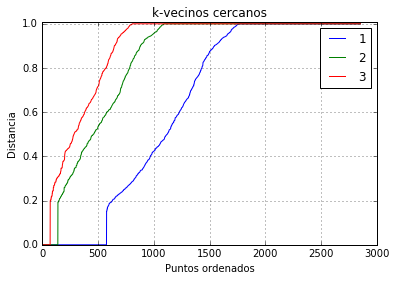

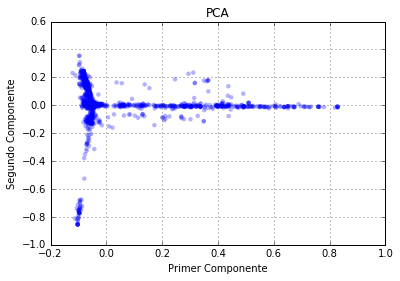

In [10]:
plot_clust_dbscan(tfs_all[0])

### Segundo día

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:57: DeprecationWarning: Passing additional arguments to the metric function as **kwargs is deprecated and will no longer be supported in 0.18. Use metric_params instead.


Estimated number of clusters: 10
Silhouette Coefficient: -0.243


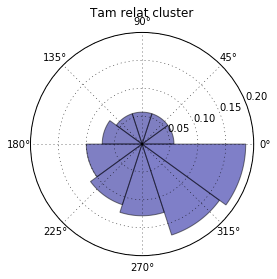

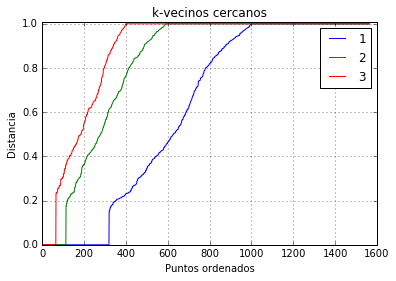

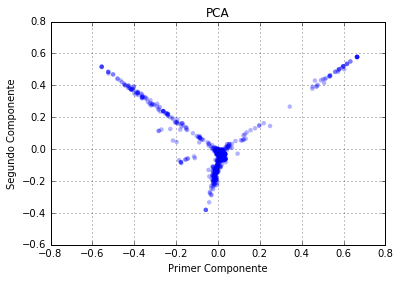

In [11]:
plot_clust_dbscan(tfs_all[1])

### Tercer día

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:57: DeprecationWarning: Passing additional arguments to the metric function as **kwargs is deprecated and will no longer be supported in 0.18. Use metric_params instead.


Estimated number of clusters: 4
Silhouette Coefficient: -0.260


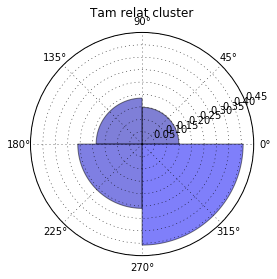

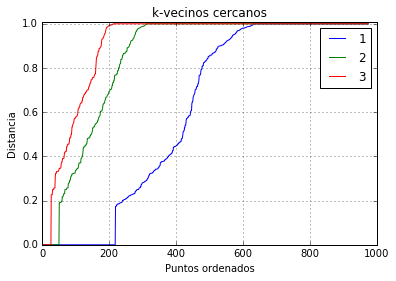

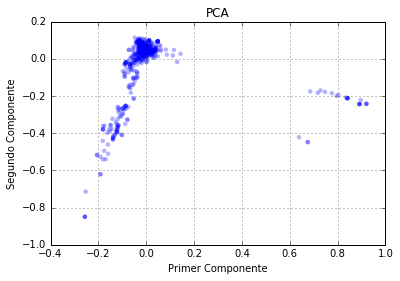

In [12]:
plot_clust_dbscan(tfs_all[2])

### Cuarto día

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:57: DeprecationWarning: Passing additional arguments to the metric function as **kwargs is deprecated and will no longer be supported in 0.18. Use metric_params instead.


Estimated number of clusters: 13
Silhouette Coefficient: -0.266


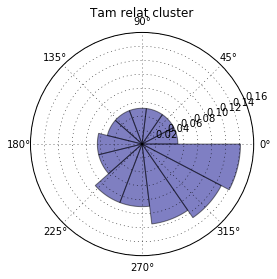

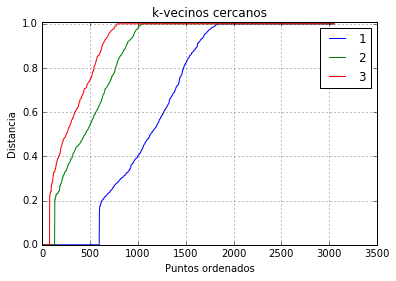

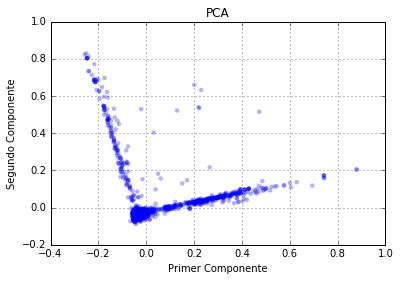

In [13]:
plot_clust_dbscan(tfs_all[3])

### Quinto día

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:57: DeprecationWarning: Passing additional arguments to the metric function as **kwargs is deprecated and will no longer be supported in 0.18. Use metric_params instead.


Estimated number of clusters: 15
Silhouette Coefficient: -0.263


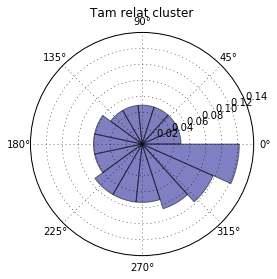

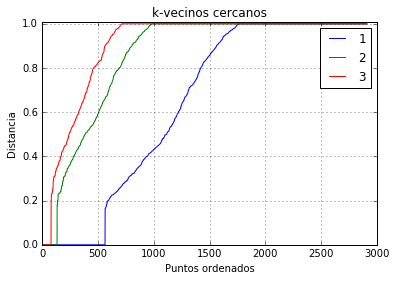

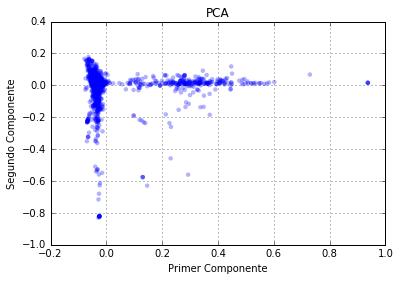

In [14]:
plot_clust_dbscan(tfs_all[4])

### Sexto día

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:57: DeprecationWarning: Passing additional arguments to the metric function as **kwargs is deprecated and will no longer be supported in 0.18. Use metric_params instead.


Estimated number of clusters: 22
Silhouette Coefficient: -0.269


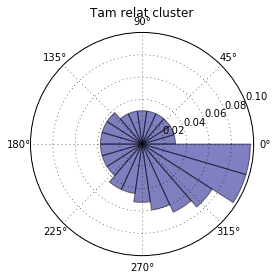

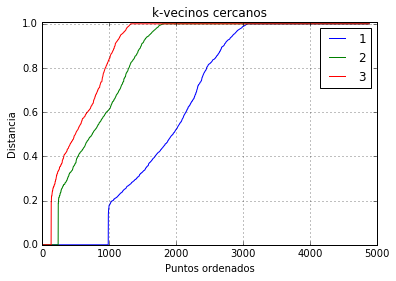

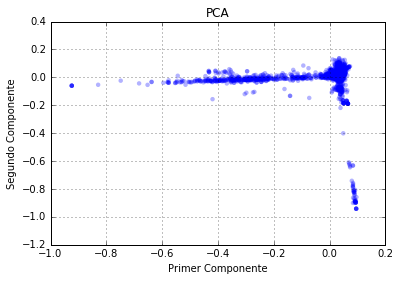

In [15]:
plot_clust_dbscan(tfs_all[5])